In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from itertools import chain 

In [2]:
def test_cv(learner, X, y, k=5):
    N = len(y)
    first = N % k
    first_n = int(N / k) + 1
    n = int(N / k)

    # print(N, first, first_n, n)

    shape = X.shape
    shuffle = np.zeros((shape[0], shape[1] + 1))
    shuffle[:, :-1] = X
    shuffle[:, -1] = y

    # np.random.shuffle(shuffle)
    per = np.random.permutation(N)

    pred = np.zeros([N, 1])

    for i in range(0, k):
        if i < first:
            from_i = i * first_n
            to_i = (i + 1) * first_n
            # print(i * first_n, (i + 1) * first_n)
        else:
            from_i = (first * first_n) + (i - first) * n
            to_i = (first * first_n) + (i - first + 1) * n
            # print((first * first_n) + (i - first) * n, (first * first_n) + (i - first + 1) * n)

        Xi_train = np.delete(shuffle, np.s_[per[from_i:to_i]], 0)
        Xi_test = shuffle[per[from_i:to_i]]

        c = learner.fit(Xi_train[:, :-1], Xi_train[:, -1])
        
        pred[per[from_i:to_i]] = np.array(c.predict(Xi_test[:, :-1])).reshape(len(pred[per[from_i:to_i]]), 1)
        RRMSE_max_hr = 1 - r2_score(y[per[from_i:to_i]], pred[per[from_i:to_i]])
        print(RRMSE_max_hr)

    return pred

In [3]:
df = pd.read_csv("data/basic2.csv")
df.head()

,Unnamed: 0,Smoked,PhysInactive,Aritmia,waist,bodyfat,fvc,fev1,AnyMeds AN do AY,All_disease,...,CR_Code_4.0,CR_Code_5.0,ethnic_code_1.0,ethnic_code_2.0,ethnic_code_3.0,ethnic_code_4.0,ethnic_code_5.0,max_hr,vo2_l_min,vo2_ml_kg_min
0,0,0.0,1.0,0.0,0.333921,0.150895,0.452555,0.320819,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,5.15300,47.8
1,1,0.0,1.0,0.0,0.385551,0.300159,0.416058,0.462457,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,142.0,2.66304,45.6
2,2,0.0,0.0,0.0,0.385551,0.537049,0.416058,0.462457,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,160.0,2.64000,29.0
3,4,1.0,1.0,0.0,0.409780,0.259484,0.416058,0.462457,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,183.0,1.98000,22.9
4,5,0.0,0.0,0.0,0.385551,0.300159,0.108029,0.121160,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1.96800,27.8


# HRmax

In [4]:
X = df.drop(['max_hr', 'vo2_l_min', 'vo2_ml_kg_min', 'Unnamed: 0'], axis=1)
y = df['max_hr']

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=69)

SVM

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [8]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [9]:
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=3)

In [10]:
# May take a while!
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# best {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [11]:
svr = SVR(C=10.0, kernel='rbf', gamma=1.0)

res_svm = test_cv(svr, X, y, k=10)
RRMSE_max_hr = 1 - r2_score(y, res_svm)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y, res_svm)))

y_res = list(chain.from_iterable(res_svm))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y + y_res) / 2), y=(y - y_res))

KeyboardInterrupt: 

Neural Networks

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model

In [64]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# input layer
model.add(Dense(27,  activation='relu'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(1))

# compile model
model.compile(optimizer='adam',loss='mse')

In [65]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=100, # drgac dej 500
          batch_size=32,
          validation_data=(X_test, y_test), 
          )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

500/500 [==============================] - 1s 1ms/step - loss: 10706.4062 - val_loss: 1362.9004
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 3811.0798 - val_loss: 715.7242
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 3427.0391 - val_loss: 752.9692
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 3293.2092 - val_loss: 559.7990
Epoch 5/100
500/500 [==============================] - 1s 1ms/step - loss: 3033.79

500/500 [==============================] - 1s 1ms/step - loss: 932.0861 - val_loss: 222.4896
Epoch 72/100
500/500 [==============================] - 1s 1ms/step - loss: 946.9022 - val_loss: 229.4851
Epoch 73/100
500/500 [==============================] - 1s 1ms/step - loss: 951.0010 - val_loss: 234.9993
Epoch 74/100
500/500 [==============================] - 1s 1ms/step - loss: 955.8310 - val_loss: 216.7073
Epoch 75/100
500/500 [==============================] - 1s 1ms/step - loss: 938.3323 - val_loss: 260.9355
Epoch 76/100
500/500 [==============================] - 1s 1ms/step - loss: 947.5142 - val_loss: 230.5169
Epoch 77/100
500/500 [==============================] - 0s 996us/step - loss: 920.1599 - val_loss: 218.7945
Epoch 78/100
500/500 [==============================] - 0s 896us/step - loss: 931.0759 - val_loss: 225.1705
Epoch 79/100
500/500 [==============================] - 0s 916us/step - loss: 919.6870 - val_loss: 223.4673
Epoch 80/100
500/500 [==============================]

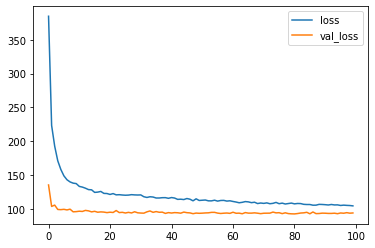

In [30]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

------------------------------
OVERALL RRMSE
0.8181483070836197
OVERALL RMSE
9.690968295770297


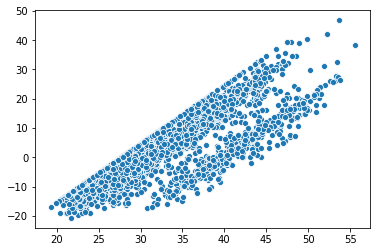

In [31]:
res_nn = model.predict(X_test)
RRMSE_max_hr = 1 - r2_score(y_test, res_nn)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_test, res_nn)))

y_res = list(chain.from_iterable(res_nn))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_test + y_res) / 2), y=(y_test - y_res))

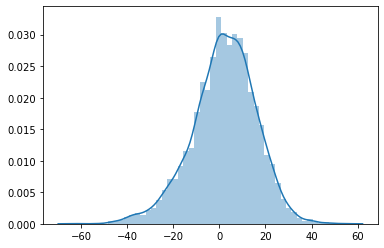

In [17]:
sns.distplot(y_test - y_res, bins= 50)

In [18]:
mean = (y_test - y_res).mean()
std = (y_test - y_res).std()
print(mean, "+-", std)

2.041697610483931 +- 13.865970807294566


# VO2max

In [23]:
X = df.drop(['max_hr', 'vo2_l_min', 'vo2_ml_kg_min', 'Unnamed: 0'], axis=1)
y = df['vo2_ml_kg_min']

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=69)

SVM

In [24]:
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.121, total=   9.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.129, total=   9.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.118, total=   9.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.135, total=   9.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.133, total=   9.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.094, total=   9.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.101, total=   9.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.096, total=   9.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.103, total=   9.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.126, total=   9.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.138, total=   9.6s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.126, total=   9.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.138, total=   9.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.139, total=   9.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.097, total=   9.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.104, total=   9.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.140, total=   9.5s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.142, total=   9.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.124, total=   9.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.136, total=   9.5s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.124, total=   9.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.135, total=   9.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.136, total=   9.5s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 23.4min finished


{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
# best {'C': 10, 'gamma': 1, 'kernel': 'rbf'} ?????

In [25]:
svr = SVR(C=10.0, kernel='rbf', gamma=1.0)

res_svm = test_cv(svr, X, y, k=10)
RRMSE_max_vo2 = 1 - r2_score(y, res_svm)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_vo2)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y, res_svm)))

y_res = list(chain.from_iterable(res_svm))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y + y_res) / 2), y=(y - y_res))

0.8130894651335094
0.8021888013585058
0.815205622290021


KeyboardInterrupt: 

Neural Networks

In [28]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# input layer
model.add(Dense(27,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))

# compile model
model.compile(optimizer='adam',loss='mse')

{'fit_time': array([13.63558936, 14.32268405, 14.36862779, 13.93578768, 13.32043386,
        13.34031224, 13.47694349, 13.40022349, 13.37721229, 13.3473618 ]),
 'score_time': array([0.03787494, 0.04191828, 0.04089355, 0.03982425, 0.03783011,
        0.04488039, 0.04388309, 0.04385877, 0.04487991, 0.04687548]),
 'test_r2': array([ 0.07447256,  0.10211034,  0.0674284 ,  0.05077497, -0.06318418,
         0.04422044,  0.30400235,  0.29560719,  0.35846926,  0.31993943]),
 'train_r2': array([0.35651244, 0.35290797, 0.35715627, 0.35808793, 0.3694436 ,
        0.36360709, 0.33787102, 0.3404265 , 0.33585132, 0.33661656]),
 'test_neg_mean_squared_error': array([ -87.92301399,  -79.22612193,  -81.10090336,  -76.93593672,
         -90.10698004, -104.59998467, -100.42270229,  -94.30130868,
         -88.11382475,  -95.732282  ]),
 'train_neg_mean_squared_error': array([-75.0763559 , -76.23672658, -75.95677102, -76.582023  ,
        -75.23228197, -73.58505328, -74.05717571, -74.80408792,
        -75.

0.7538075551314556
0.7373327592596516
0.7516231002486984
0.7344829701068305
0.7148027564898498
0.7361585410011309
0.7631359954211338
0.7315206675065749
0.7503988153858447
0.730263239650471
------------------------------
OVERALL RRMSE
0.7398793645192125
OVERALL RMSE
9.258980312116837


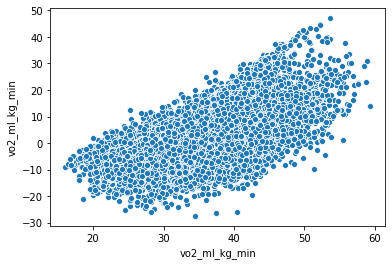

In [29]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=100, # drgac dej 500
          batch_size=32,
          validation_data=(X_test, y_test), 
          )

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
res_nn = model.predict(X_test)
RRMSE_max_vo2 = 1 - r2_score(y_test, res_nn)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_vo2)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_test, res_nn)))

y_res = list(chain.from_iterable(res_nn))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_test + y_res) / 2), y=(y_test - y_res))

In [35]:
from sklearn import datasets

In [36]:
iris = datasets.load_iris()

In [43]:
iris.target
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris.data, np.ravel(iris.target), test_size=0.25, random_state=69)

In [58]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# input layer
model.add(Dense(4,  activation='relu'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.4))

# hidden layer
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(3))

# compile model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

In [59]:
X_train_iris


array([[7. , 3.2, 4.7, 1.4],
       [5.9, 3. , 5.1, 1.8],
       [5.7, 4.4, 1.5, 0.4],
       [6.4, 3.2, 5.3, 2.3],
       [5.4, 3. , 4.5, 1.5],
       [4.8, 3.1, 1.6, 0.2],
       [6.9, 3.1, 4.9, 1.5],
       [4.9, 2.4, 3.3, 1. ],
       [5.8, 2.7, 5.1, 1.9],
       [6.3, 2.5, 4.9, 1.5],
       [5.7, 2.6, 3.5, 1. ],
       [6.4, 2.9, 4.3, 1.3],
       [6.9, 3.1, 5.1, 2.3],
       [5. , 3.4, 1.6, 0.4],
       [6.7, 3. , 5. , 1.7],
       [7.4, 2.8, 6.1, 1.9],
       [6.3, 2.8, 5.1, 1.5],
       [6.4, 2.8, 5.6, 2.2],
       [6.3, 3.3, 4.7, 1.6],
       [5.2, 3.4, 1.4, 0.2],
       [5.7, 2.8, 4.1, 1.3],
       [6.4, 3.2, 4.5, 1.5],
       [6.5, 3.2, 5.1, 2. ],
       [6.1, 2.8, 4. , 1.3],
       [5. , 2. , 3.5, 1. ],
       [4.9, 3.6, 1.4, 0.1],
       [6.3, 2.3, 4.4, 1.3],
       [5.1, 2.5, 3. , 1.1],
       [5. , 3. , 1.6, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [6.7, 3.1, 4.4, 1.4],
       [4.6, 3.4, 1.4, 0.3],
       [4.8, 3. , 1.4, 0.1],
       [6.2, 2.9, 4.3, 1.3],
       [4.9, 3

In [60]:
model.fit(x=X_train_iris, 
          y=y_train_iris, 
          epochs=100, # drgac dej 500
          batch_size=16,
          validation_data=(X_test_iris, y_test_iris), 
          )

Epoch 1/100
7/7 [==============================] - 0s 20ms/step - loss: 3.2750 - val_loss: 7.0549
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 3.5432 - val_loss: 7.0438
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 3.2568 - val_loss: 7.0471
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 3.2897 - val_loss: 7.0279
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 2.6666 - val_loss: 7.0133
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 3.5797 - val_loss: 7.0135
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 3.5412 - val_loss: 7.0076
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 3.1140 - val_loss: 6.9876
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 3.4644 - val_loss: 6.9839
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 2.9384 - val_loss: 6.9637
Epoch 11/100
7/7 [==========

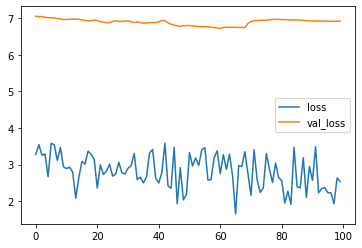

In [61]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()